In [1]:
%matplotlib inline



Modifying data in-place
=======================



In [2]:
from __future__ import print_function

import mne
import os.path as op
import numpy as np
from matplotlib import pyplot as plt

It is often necessary to modify data once you have loaded it into memory.
Common examples of this are signal processing, feature extraction, and data
cleaning. Some functionality is pre-built into MNE-python, though it is also
possible to apply an arbitrary function to the data.



In [5]:
# Load an example dataset, the preload flag loads the data into memory now
data_path = op.join(mne.datasets.sample.data_path(), 'MEG',
                    'sample', 'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(data_path, preload=True, add_eeg_ref=False)
# Corto de 0 a 10 segundos
raw = raw.crop(0, 10)
print(raw)


Opening raw data file /home/marat/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 6007 (10.0 sec), ~21.0 MB, data loaded>


Signal processing
-----------------

Most MNE objects have in-built methods for filtering:



In [7]:
raw.filter?

Band-pass filtering from 1 - 3 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 3724 samples (6.200 sec) selected
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14


<ipython-input-8-045fde1cddae>:7: DeprecationWarning: fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
  filter_length='auto', phase='zero')


Band-pass filtering from 3 - 10 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Filter length of 1862 samples (3.100 sec) selected
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14


<ipython-input-8-045fde1cddae>:7: DeprecationWarning: fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
  filter_length='auto', phase='zero')


Band-pass filtering from 10 - 20 Hz
l_trans_bandwidth chosen to be 2.5 Hz
h_trans_bandwidth chosen to be 5.0 Hz
Filter length of 1490 samples (2.481 sec) selected
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14


<ipython-input-8-045fde1cddae>:7: DeprecationWarning: fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
  filter_length='auto', phase='zero')


Band-pass filtering from 20 - 60 Hz
l_trans_bandwidth chosen to be 5.0 Hz
h_trans_bandwidth chosen to be 15.0 Hz
Filter length of 745 samples (1.240 sec) selected
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14


<ipython-input-8-045fde1cddae>:7: DeprecationWarning: fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
  filter_length='auto', phase='zero')


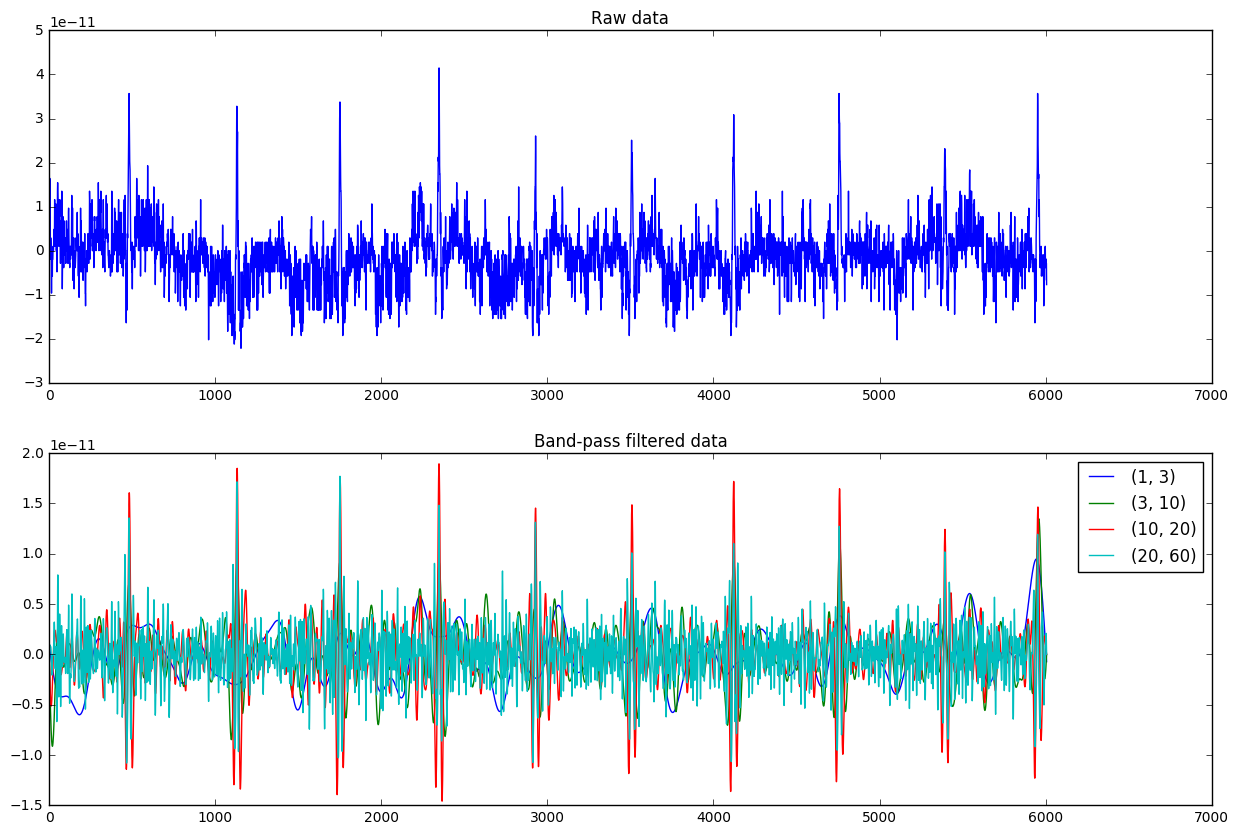

In [8]:
filt_bands = [(1, 3), (3, 10), (10, 20), (20, 60)]
f, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 10))
_ = ax.plot(raw._data[0])
for fband in filt_bands:
    raw_filt = raw.copy()
    raw_filt.filter(*fband, h_trans_bandwidth='auto', l_trans_bandwidth='auto',
                    filter_length='auto', phase='zero')
    _ = ax2.plot(raw_filt[0][0][0])
ax2.legend(filt_bands)
ax.set_title('Raw data')
ax2.set_title('Band-pass filtered data')

In addition, there are functions for applying the Hilbert transform, which is
useful to calculate phase / amplitude of your signal.



In [11]:
# Filter signal with a fairly steep filter, then take hilbert transform

raw_band = raw.copy()
raw_band.filter(12, 18, l_trans_bandwidth=2., h_trans_bandwidth=2.,
                filter_length='auto', phase='zero')
raw_hilb = raw_band.copy()

hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
raw_hilb.apply_hilbert(hilb_picks)
print(raw_hilb._data.dtype)

Band-pass filtering from 12 - 18 Hz
Filter length of 1862 samples (3.100 sec) selected
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14


<ipython-input-11-94b9a49f2bbb>:5: DeprecationWarning: fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
  filter_length='auto', phase='zero')


n_fft is None by default in 0.13 but will change to "auto" in 0.14


<ipython-input-11-94b9a49f2bbb>:9: DeprecationWarning: n_fft is None by default in 0.13 but will change to "auto" in 0.14
  raw_hilb.apply_hilbert(hilb_picks)


complex64


Finally, it is possible to apply arbitrary functions to your data to do
what you want. Here we will use this to take the amplitude and phase of
the hilbert transformed data.

<div class="alert alert-info"><h4>Note</h4><p>You can also use ``amplitude=True`` in the call to
          :meth:`mne.io.Raw.apply_hilbert` to do this automatically.</p></div>




/home/marat/.pyenv/versions/2.7.11/envs/mne/lib/python2.7/site-packages/mne/io/base.py:822: ComplexWarning: Casting complex values to real discards the imaginary part
  self._data = self._data.astype(dtype)


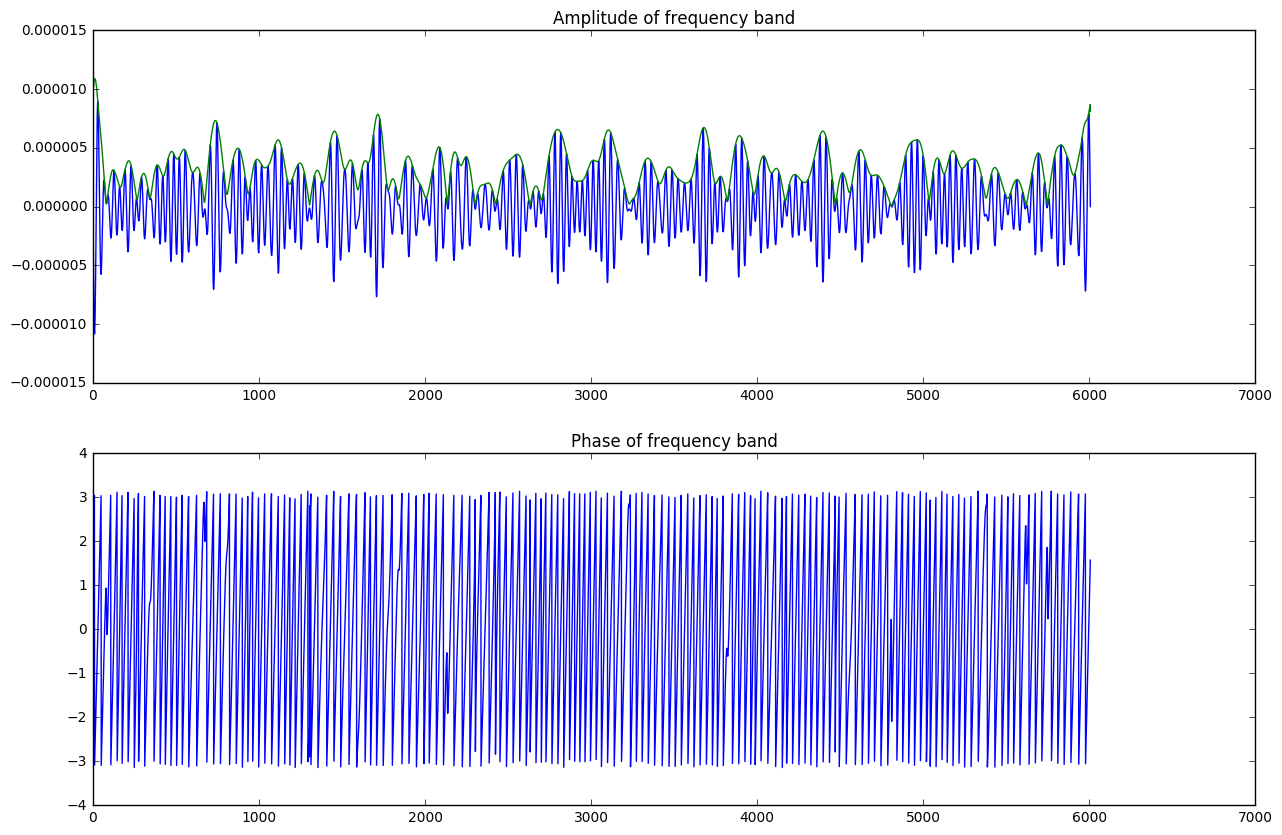

In [12]:
# Take the amplitude and phase
raw_amp = raw_hilb.copy()
raw_amp.apply_function(np.abs, hilb_picks, float, 1)
raw_phase = raw_hilb.copy()
raw_phase.apply_function(np.angle, hilb_picks, float, 1)

f, (a1, a2) = plt.subplots(2, 1, figsize=(15, 10))
a1.plot(raw_band._data[hilb_picks[0]])
a1.plot(raw_amp._data[hilb_picks[0]])
a2.plot(raw_phase._data[hilb_picks[0]])
a1.set_title('Amplitude of frequency band')
a2.set_title('Phase of frequency band')